# 실습 - Titanic 호 data 를 이용한 Feature Engineering 과 Modeling

Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)  $\rightarrow$ 객실 등급  
survival -  Survival (0 = 사망; 1 = 생존)  $\rightarrow$ 생존여부  (지도학습의 정답 데이터, 레이블)
name - Name  
sex - Sex  
age - Age  
sibsp - Number of Siblings/Spouses Aboard  $\rightarrow$ 함께 탑승한 형제 또는 배우자 수   
parch - Number of Parents/Children Aboard  $\rightarrow$ 함께 탑승한 부모 또는 자녀 수  
ticket - Ticket Number  
fare - Passenger Fare (British pound)  
cabin - Cabin  $\rightarrow$ 선실번호  
embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)  $\rightarrow$ 탑승한 항구(얼마나 부유한지와 관련)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("datasets/titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# 중요하지 않은 칼럼들을 삭제해주는 과정
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [3]:
df.drop(['PassengerId','Name', 'Ticket', 'Cabin'],axis=1, inplace=True) # 실제로 pd에서 날려버림
df.head() # 노이즈, 필요없는 데이터 칼럼을 삭제함, 정답과 무관한 칼럼들은 없애주는게 좋은

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [5]:
df.info() #891entries가 있음
# Age를 보니깐 714 non-null --> 100개 정도의 결측치가 있음 
# Embarked에 는 2의 결측치가 있음 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [8]:
df.isnull() # null인 것은 true, null이 아닌 것은 false 이렇게 나옴
# Age 칼럼의 888행은 null(True) --> 결측치가 존재한다. 

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
886,False,False,False,False,False,False,False,False
887,False,False,False,False,False,False,False,False
888,False,False,False,True,False,False,False,False
889,False,False,False,False,False,False,False,False


In [10]:
df.isnull().sum() # 결측치의 갯

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [12]:
df.describe() # 데이터프레임의 기술통계

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Feature Analysis

- feature 간의 correlation check

- Survived 와 각 Feature 간 상관관계 파악

In [19]:
# df.cov() 공분산, 어떤 변수가 하나 증가할 때 다른 변수가 얼마나 증가하냐
# 공분산으로 계산하면 어렵기에 정규화 시킨 것 -1~+1 사이로 정규화 시킨것이 상관관계

In [20]:
df.corr(numeric_only=True) # survived과 가장 높은 관계가 있는 건 Fare(25%의 관계가 있음)
# PClass는 1등석으로 갈수록 생 확률이 높다, 마이너스 값은 역의 상관관계가 있따는 것.

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


<Axes: >

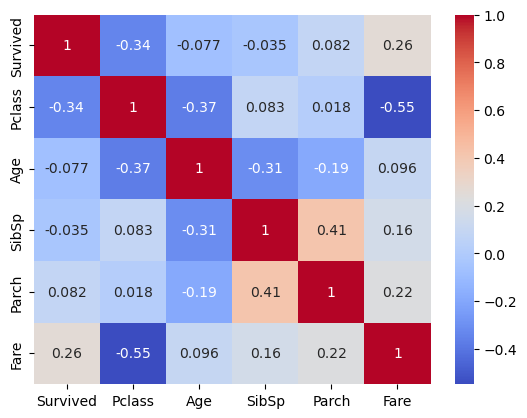

In [23]:
import seaborn as sns
sns.heatmap(df.corr(numeric_only=True),annot = True, cmap = 'coolwarm')
# 대각선이 가장 높은 이유는 --> 자기 자신이 자기 자신이랑 젤 연관 높으니깐
# Fare하고 Pclass은 아주 강한 역의 관계가 있음
# 1,2,3등석이니깐 Pclass 숫자가 클수록 Fare이랑 역의 관계가 있음
# 그래서 Fare가 비싸질수록 pClass는 숫자가 내려감.

가장 상관 관계가 높은 feature 는 Fare 이고 Pclass 는 가장 상관관계가 낮은 것으로 나타난다.

## Missing Value 처리

In [24]:
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [28]:
# age는 평균으로, Embarked 2개는 그냥 삭제하겠다
df['Age'].fillna(df['Age'].median(), inplace = True)

C:\Users\esroh\AppData\Local\Temp\ipykernel_11660\2848288209.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace = True)


In [30]:
df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [33]:
df.dropna(inplace = True)
df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

881 개의 data 중 170 개를 drop 시키는 것은 너무 많은 양이므로 Age 는 median 으로 채워주고 Embarked 는 drop 시킨다.

## Data 의 skewness  check

(array([ 54.,  46., 177., 346., 117.,  70.,  45.,  23.,   9.,   2.]),
 array([ 0.42 ,  8.378, 16.336, 24.294, 32.252, 40.21 , 48.168, 56.126,
        64.084, 72.042, 80.   ]),
 <BarContainer object of 10 artists>)

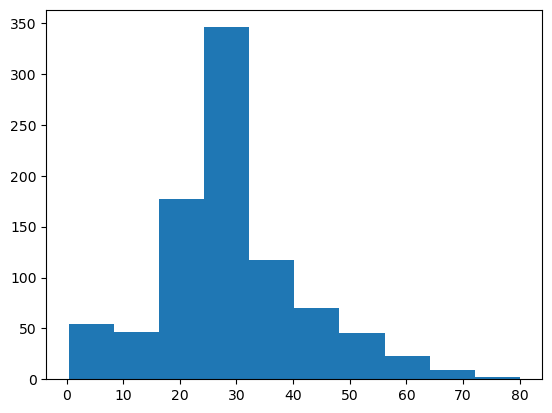

In [35]:
# matplotlib 에서 histogram을 그리는 방법 
# 데이터프레임, 판다스가 matplotlib을 내장하고 있음 
plt.hist(df['Age'])

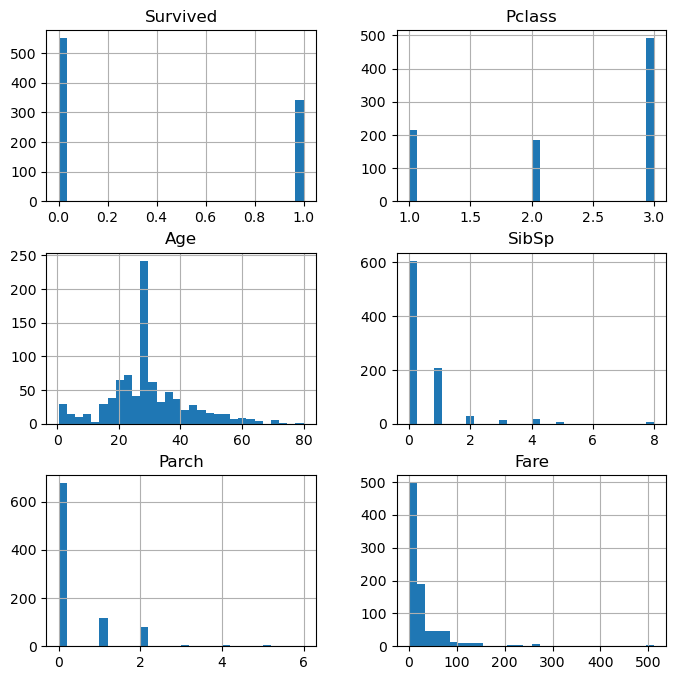

In [39]:
df.hist(bins = 30, figsize = (8,8))
plt.show() # plt.show()를 하면 시각화 그래프 위에 문구가 사라짐 
# survived 보니깐 죽은 사람이 더 많음
# 나이는 다 중간값으로 채워서 30살 정도가 젤 많음 

### Fare 의 분포가 심하게 skew 되어 있으므로 log 값으로 바꾸어 skewness 를 완화 시킨다.

In [41]:
df['Fare'] = df['Fare'].map(lambda x: np.log(x) if x > 0 else 0)  # 로그를 취한 값으로 Fare을 적용해준다. 

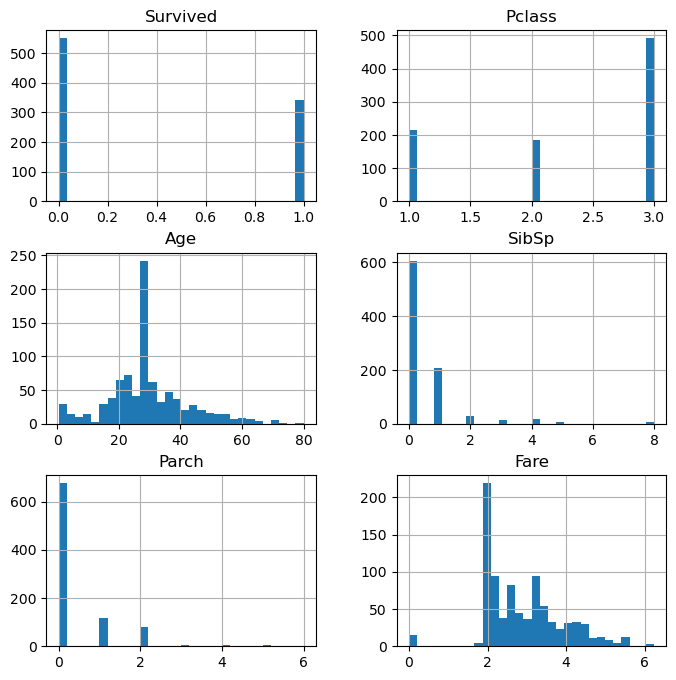

In [42]:
df.hist(bins = 30, figsize = (8,8))
plt.show() # Fare 부분만 우리가 바꿔줬음. 데이터가 가운데로 정렬됨.
# 큰 숫자는 작아보이게 하고 작은 숫자느 커 보이게 하는데 대소관계를 절대 안 바꿈
# 실제로 로그를 취해도 그 숫자에 그 칼럼의 특성은 전혀 바뀌지 않음 --?? 멤버들과 공유할 내용
# 대소관계가 유지된 상태로 숫자가 바뀐다??

## Category 변수 처리

Category column 들을 one-hot-encoding 으로 변환한다.

In [43]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,1.981001,S
1,1,1,female,38.0,1,0,4.266662,C
2,1,3,female,26.0,0,0,2.070022,S
3,1,1,female,35.0,1,0,3.972177,S
4,0,3,male,35.0,0,0,2.085672,S


In [46]:
# 카테고리 변수 처리해주는 방법 = get_dummies -> 카테고리인 것들만 골라가지고 데이터 프레임을 바꿔줌.
df = pd.get_dummies(df)
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,1.981001,False,True,False,False,True
1,1,1,38.0,1,0,4.266662,True,False,True,False,False
2,1,3,26.0,0,0,2.070022,True,False,False,False,True
3,1,1,35.0,1,0,3.972177,True,False,False,False,True
4,0,3,35.0,0,0,2.085672,False,True,False,False,True


## Train / Test dataset split

In [47]:
df.shape

(889, 11)

In [49]:
y = df['Survived'].values
X = df.drop('Survived', axis = 1).values
X.shape, y.shape # 10개의 피처로 이뤄진 훈련 데이터, 1개의 피처로 이뤄진 정답 데이터 survived

((889, 10), (889,))

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state = 0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((711, 10), (178, 10), (711,), (178,))

## Standard Scaling

In [54]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test) # fit 하면 안됨

## Modeling

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators = 10, random_state= 0, criterion = 'entropy')
rf.fit(X_train, y_train) # 모델 학습 완료, fit

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [61]:
y_pred = rf.predict(X_test)

accuracy_score(y_test,y_pred) # 76% 맞았음 , criterion을 entropy로 바꾸니깐 75%로 바

0.7528089887640449